In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_blobs

%matplotlib inline

# Review

## Time and Space Complexity ✨Vibes✨

### KNN
- How is a KNN model "trained"? Is this a faster or slower process than the other model's we've learned?
- What do I need to store to make a prediction with a trained KNN model? How would that change if I added a new *row*? How would that change if I added a new *predictor*?

### Naive Bayes
- How does a trained Naive Bayes model make a prediction?
- Would adding a new *row* change how quickly I can make that prediction? What about adding a new *predictor*?
- Would adding a new *row* change how many values I need to store to make a prediction? What about adding a new *predictor*?

## Naive Bayes
### Naive
Naive Bayes is **Naive** because it makes the assumption of **conditional independence**. This means that within classes (the groups we're trying to predict), we assume the predictors are *independent*. However we know that's not true, so it's a *Naive* assumption to make.

However, it simplifies our computation. When events are *independent* we can calculate their joint probability just by multiplying them:

$$\underbrace{P(A,B,C)}_\text{probability of A, B, and C} = P(A) * P(B) * P(C)$$

Rather than calculating the joint probability $P(A,B,C)$ by taking into account any relationships between the predictors.

### Bayes
When classifying a data point, we use Bayes' Theorem (at least the numerator of it) to calculate the *score* for each potential category. Then we choose the category with the highest score. Because we're comparing scores that have the same denominator, we can ignore it (which is nice, as it's difficiult to calculate).

$$ \overbrace{P(\text{group}_i | \mathbf{X}) = \frac{P(\mathbf{X} | \text{group}_i) * P(\text{group}_i)}{P(\mathbf{X})}}^\text{Bayes' Theorem}$$

- $P(\text{group}_i | \mathbf{X})$ is the probability of our data point being in group $i$ based on their predictor values $\mathbf{X}$
- $P(\mathbf{X} | \text{group}_i)$ is the likelihood of seeing features like $\mathbf{X}$ in group $i$ (if our features are commonly seen in group $i$, we're more likely to predict you're in group $i$)
- $P(\text{group}_i)$ is the probability of being in group $i$ overall (if a group is very rare, we don't want to predict it often)
- $P(\mathbf{X})$ is the probability of seeing features like $\mathbf{X}$ overall, in any group (but we ignore this term)

## Naive Bayes in `sklearn`

- `GaussianNB()`
- `BernoulliNB()`
- `CategoricalNB()`

In [ ]:
bey = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/Beyonce_data.csv")
bey.head()


predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
nb = GaussianNB()

# create z score object
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

# make pipeline
pipe = Pipeline([("pre", z), ("model", nb)])

# fit
pipe.fit(X_train, y_train)

# predict

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.741424802110818
Train Prescision:  0.7669616519174042
Train Recall    :  0.931899641577061
Train F1        :  0.8414239482200647
Train ROC AUC   :  0.6957706093189964
Test Acc        :  0.7789473684210526
Test Prescision :  0.8095238095238095
Test Recall     :  0.9315068493150684
Test F1         :  0.8662420382165604
Test ROC AUC    :  0.7135740971357409


## KNN
KNN is a simple, distance based algorithm that let's us CLASSIFY data points based on what class the data points around them are.

Despite it being distance based, KNN is a *classification* algorithm. In other words, it is supervised machine learning, as it requires truth labels (the actual class/group). However it does share characteristics with clustering algorithms we will see later.

KNN *can* work with binary/categorical variables, but not without some tweaking which we do not cover here.

### Hyperparameters

Hyperparameters are parameters in our model that are NOT chosen by the algorithm (we must supply them). We can either choose them:

- based on domain expertise (knowledge about the data)
- based on the data (hyperparameter tuning)

Why do we have to use a validation set when hyperparameter tuning?


### Building a KNN Model

In [ ]:
bey = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/Beyonce_data.csv")
bey.head()

# what K do I use??
predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

# make pipeline
pipe = Pipeline([("pre", z), ("model", knn2)])

# choose potential values of k
ks = {"model__n_neighbors": [1,2,5,10,20]}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = "precision", cv = 5, refit = True)

grid.fit(X_train, y_train)

print("GridSearchCV chose: ", grid.best_estimator_.get_params()["model__n_neighbors"])

# predict
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

y_pred_train_prob = grid.predict_proba(X_train)[:,1]
y_pred_test_prob = grid.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

GridSearchCV chose:  2
Train Acc       :  0.941952506596306
Train Prescision:  1.0
Train Recall    :  0.9236111111111112
Train F1        :  0.9602888086642599
Train ROC AUC   :  0.9895070207570207
Test Acc        :  0.8105263157894737
Test Prescision :  0.8709677419354839
Test Recall     :  0.84375
Test F1         :  0.8571428571428571
Test ROC AUC    :  0.8147681451612904



## KNN plotting

(this will only work with specific 2D data, if you wanted to use it for your own data you'd need to change the code to do so)

K-Nearest Neighbors is a straightforward algorithm: given a training set, classify a new (unknown) data point by counting the K nearest known points, and choosing the most common classification.

In this classwork we'll use ggplot to plot the boundaries of knn, and see how the size, shape, and overlap of clusters affect these boundries.

In [2]:
def plotKNN2D(Xdf,y,k):
    # X can only have 2 dimensions becuase of plotting

    #grab the range of features for each feature
    x0_range = np.linspace(min(Xdf[Xdf.columns[0]]) - np.std(Xdf[Xdf.columns[0]]),
                           max(Xdf[Xdf.columns[0]]) + np.std(Xdf[Xdf.columns[0]]), num = 100)
    x1_range = np.linspace(min(Xdf[Xdf.columns[1]]) - np.std(Xdf[Xdf.columns[1]]),
                           max(Xdf[Xdf.columns[1]]) + np.std(Xdf[Xdf.columns[1]]), num = 100)

    #get all possible points on graph
    x0 = np.repeat(x0_range,100)
    x1 = np.tile(x1_range,100)
    x_grid = pd.DataFrame({Xdf.columns[0]: x0, Xdf.columns[1]: x1})

    #build model

    knn = KNeighborsClassifier(n_neighbors = k)
    pipe = Pipeline([("model",knn)])

    pipe.fit(Xdf,y)

    # predict all background points
    p = pipe.predict(x_grid)
    x_grid["p"] = p #add to dataframe

    #build the plot
    bound = (ggplot(x_grid, aes(x = Xdf.columns[0], y = Xdf.columns[1], color = "factor(p)")) +
                 geom_point(alpha = 0.2, size = 0.2) + theme_minimal() +
                 scale_color_manual(name = "Class", values = ["#E69F00", "#0072B2"]) +
                 geom_point(data = Xdf, mapping = aes(x = Xdf.columns[0], y = Xdf.columns[1], color = "factor(y)"), size = 2))
    display(bound)

## Explore

Let's test this function with some fake data:

In [3]:
# Generate Fake Data
centers = [(-5, -5),
           (5, 5)]
cluster_std = [1, 1]
n = 200

X, y = make_blobs(n_samples=n, cluster_std=cluster_std,
                  centers=centers, n_features=2, random_state=1)

# make it into a dataframe for ggplot
X = pd.DataFrame(X)
X.columns = ["X1", "X2"] #rename cols so they're not ints

plotKNN2D(X,y,1)

<ggplot: (640 x 480)>


## How does changing K affect the decision boundary?

Using the dataframe `dd` and using the `plotKNN2d()` function build KNN models with K = 1, 3, 5, 20, 50, 100.

**How does the decision boundary change as K changes?**

In [ ]:
dd = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/knnclasswork.csv")
dd.head()

,X1,X2,y
0,-1.710595,-5.593345,0
1,-14.912877,-3.722297,0
2,-8.533054,-5.908033,0
3,6.188479,-3.813313,0
4,-6.062674,-3.809560,0


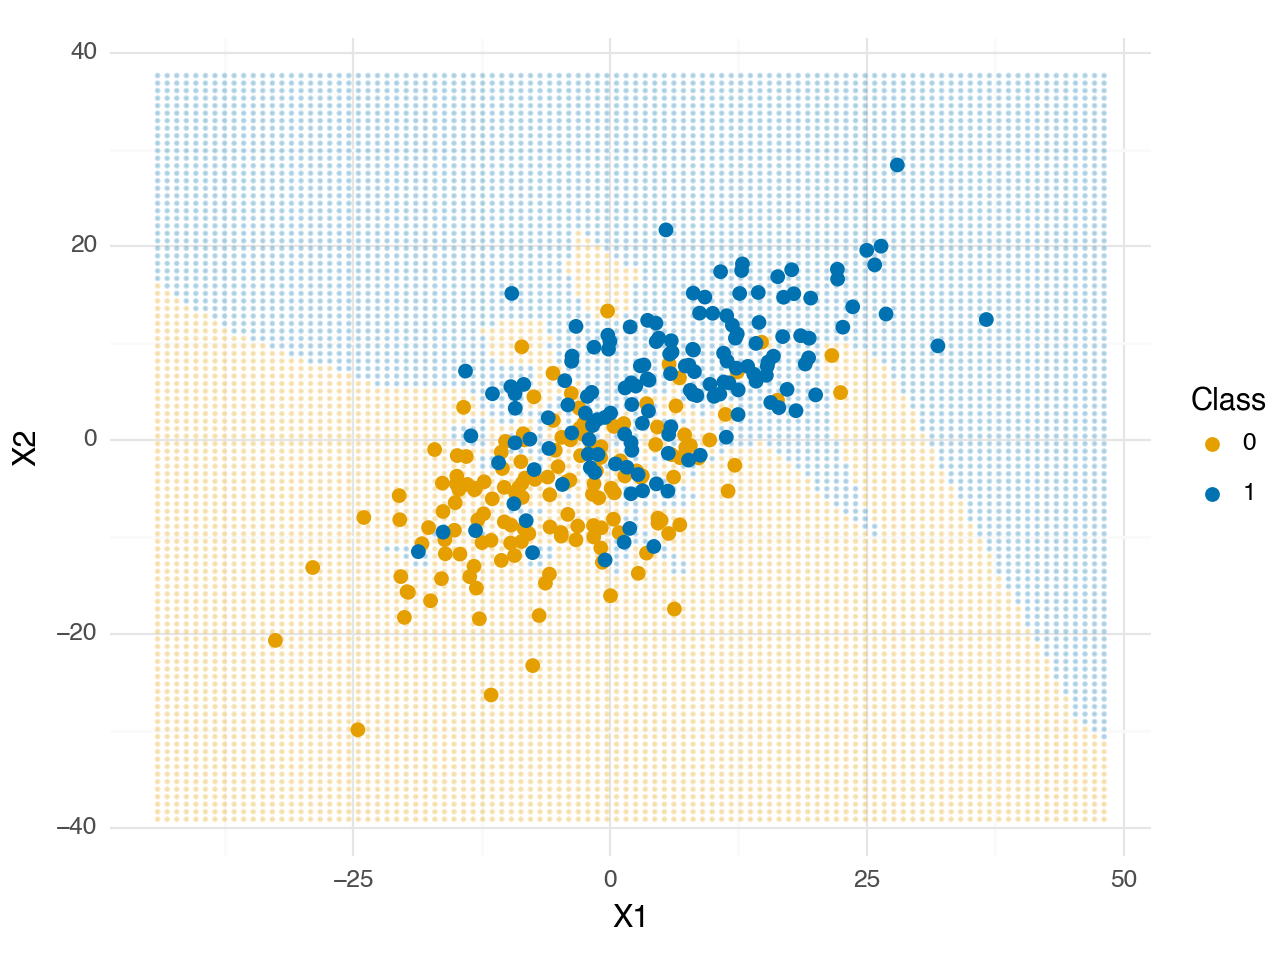

In [ ]:
### YOUR CODE HERE ###

# k = 1
plotKNN2D(dd[["X1", "X2"]],dd["y"],1)
# k = 3

# k = 5

# k = 20

# k = 50

# k = 100

##  How does changing k affect the decision boundary (imbalanced classes)?

Now let's see how changing k affects the boundary when the groups have different numbers of samples. Using the `plotKNN2d()` function, and the data loaded below (`dd2`), examine what happens to the decision boundaries as you try different k's (try 1,3,5,10, 25, 50, and **100**).

**How does changing k affect the decision boundary when the groups are imbalanced?**

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
dd2 = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/knnclasswork2.csv")
dd2.head()
### MAKE A SCATTER PLOT OF THE DATA ###


,X1,X2,y
0,3.033900,3.586612,0
1,4.787792,17.663630,1
2,7.954019,0.915931,1
3,5.804289,12.212329,1
4,-6.659940,7.114966,1


In [ ]:
### YOUR CODE HERE ###

# k = 1

# k = 3

# k = 5

# k = 20

# k = 50

# k = 100

# `KNearestNeighbors()` and `GaussianNB()`

Use data:https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/wine-quality-white-and-red.csv, and use both KNN and Gaussian Naive Bayes to predict `type` (red vs. white) in this dataset (your predictors should be ALL variables except `type` and `quality`). Use 80/20 TTS, z score your continuous interval variables, and use `GridSearchCV()` to choose `n_neighbors` in your KNN Model.


### Question

How well did your models do?
<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = “200”/>


In [ ]:
### YOUR CODE HERE ###


In [ ]:
### YOUR CODE HERE ###


## Recommendation Systems

"If you like _________________ you should listen to ___________________ by Taylor Swift."

We're going to build a **Recommendation System** to recommend Taylor Swift songs for people by letting users select a song, and then recommending the most similar songs (according to `danceability`, `energy`, `instrumentalness`, `valence`, `loudness`, `liveness`, `speechiness`, `acousticness`).

To do this, we're going to load in our [training data](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/TaylorSwiftSpotify.csv), fit a `NearestNeighbors()` model, and then for each song in our [new data](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KNNCompareSpotify.csv) we'll find the 10 most similar songs and recommend them!



In [ ]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer


%matplotlib inline
training_data = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/TaylorSwiftSpotify.csv")
new_data = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KNNCompareSpotify.csv")

feat = ["danceability", "energy", "instrumentalness", "valence", "loudness", "liveness", "speechiness", "acousticness"]


# Build Empty
z = make_column_transformer((StandardScaler(), feat))
nn = NearestNeighbors(n_neighbors= 10)
pipe = Pipeline([("z", z), ("model", nn)])
pipe.fit(training_data[feat])


# get distances, neighbors
# first grab model to make predictions, then use pre-processor to z score data
distances, neighbors = pipe.named_steps["model"].kneighbors(pipe.named_steps["z"].transform(new_data[feat]))

# add neighbors to data file
new_data = new_data.assign(neighbors = list(neighbors))
new_data.head()



In [ ]:
## you will find the indexes of the 10 songs will be stored in "neighbors" column.
### input the index of the song you'd like to listen, then you can get the 10 recommended songs
recommend=new_data.loc[1,"neighbors"]
training_data.iloc[recommend]